In [38]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
from collections import deque
import random
import time
import csv
from scipy.interpolate import make_interp_spline

# Assignment 1
## Part 1
### 1) Generate p-ER graphs and r-regular graphs with K nodes

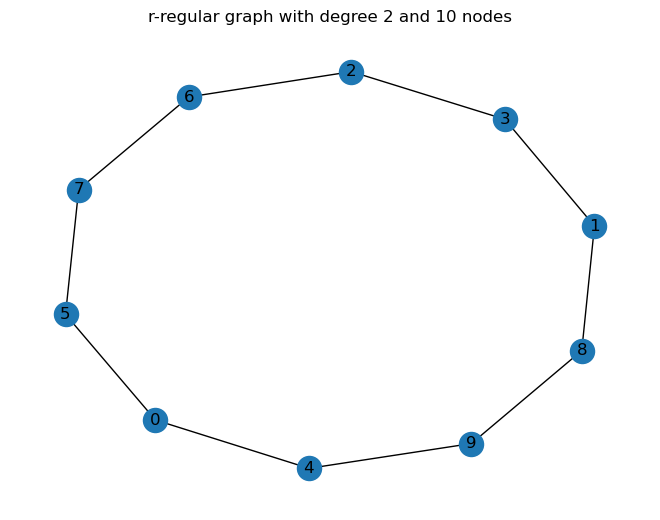

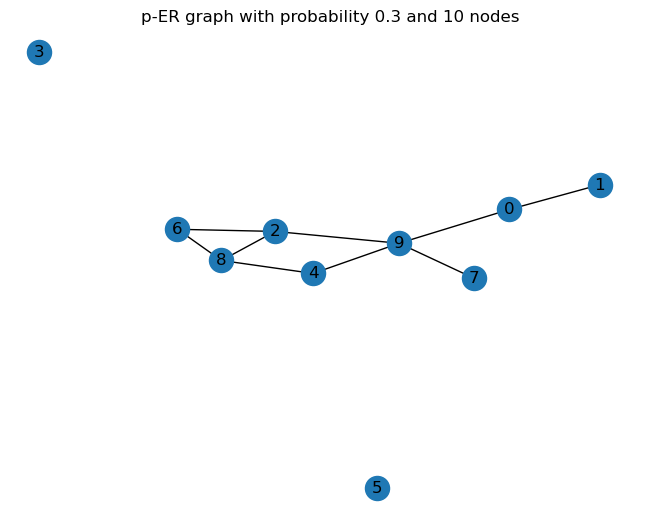

In [2]:
# Example with #nodes K = 7
K = 10

# r-regular graph
# E.g. degree r = 4
r = 2

# Generation of r-regular graph
G = nx.random_regular_graph(r, K)

# Plotting the r-regular graph
nx.draw(G, with_labels=True)
plt.title(f"r-regular graph with degree {r} and {K} nodes")
plt.savefig('r-regular-graph.png')
plt.show()

# p-ER graph
# E.g. Probability of an edge between any two nodes = 0.4
p = 0.3

# Generation of p-ER graph
H = nx.erdos_renyi_graph(K, p)

# Plotting the p-ER graph
nx.draw(H, with_labels=True)
plt.title(f"p-ER graph with probability {p} and {K} nodes")
plt.savefig('p-ER-graph.png')
plt.show()


### 2) Write a script to check the connectivity of a given graph.

First of all we implement the algebraic method with the adjacency matrix

In [3]:
# We leverage Horner Rule for matrix in order to avoid all these multiplications
def Horner(A):
    '''
    it evaluates the value of a poly a_0*x^n + a_1*x^n-1 + ...+ a_n-1*x + a_n
    using the following recursive method
    p_0 = a_0
    p_(k+1) = p_k*x+a_k+1
    '''
    #Convert the adj matrix into an array
    A = A.toarray()
    n,m = A.shape
    #check if the matrix is a square matrix
    if n != m:
        raise ValueError("Input matrix must be square.")
        
    #the inizialization evaluates the coefficient a_n
    #In this simple case, a_i = 1 for each power of x
    A_old = np.eye(n)

    #we loop till the n-1 th power
    for k in range(n-1):
        A_new = np.matmul(A,A_old) + np.eye(n)
        A_old = A_new

    return A_new

def is_connected_method_1(G):
    '''
    It checks the # connected components of the graph G
    through the irriducibility of its adjacency matrix
    '''
    #First we get the adhacency matrix of G in sparse form
    adj_matrix = nx.adjacency_matrix(G)

    # From theory we know that a graph is connected iff its nxn adjacency matrix is irriducible
    # that holds iff Id + A + A^2 + ... + A^n-1 > 0
      
    power_A = Horner(adj_matrix)
    
    # Check if all elements in A are greater than 0
    return (power_A > 0).all()

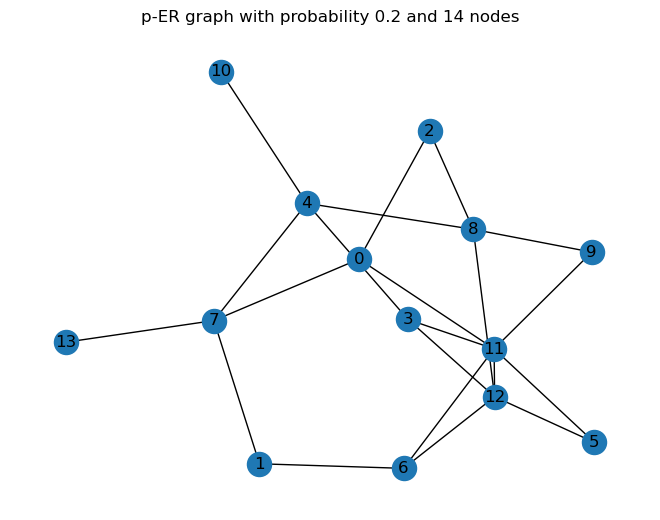

Is H connected? yes


In [6]:
# Try
K = 14
p= 0.2

# Generation of p-ER graph
H = nx.erdos_renyi_graph(K, p)

# Plotting the p-ER graph
nx.draw(H, with_labels=True)
plt.title(f"p-ER graph with probability {p} and {K} nodes")
plt.show()

#Check connection
print(f"Is H connected? {'yes' if is_connected_method_1(H) else 'no' }")

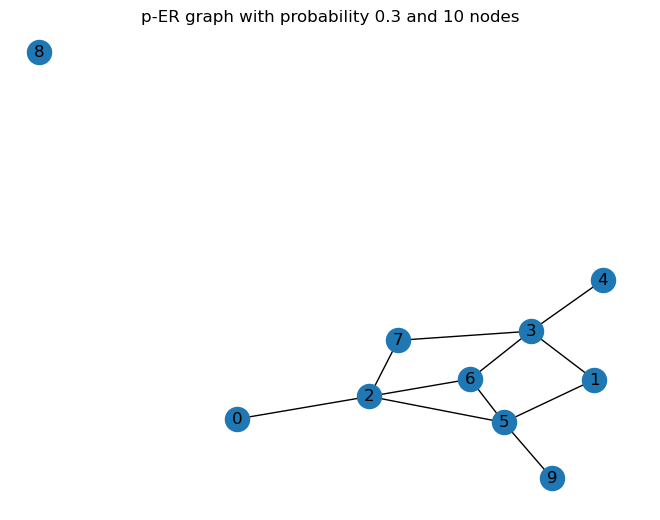

Is H connected? no


In [54]:
# Try
K = 10
p= 0.3

# Generation of p-ER graph
H = nx.erdos_renyi_graph(K, p)


#First we get the corresponding adjacency matrix
adj_matrix = nx.to_numpy_array(G)
    
# Convert the adjacency matrix to a sparse CSR matrix
#sparse_adj_matrix = sp.csr_matrix(adj_matrix)

# Plotting the p-ER graph
nx.draw(H, with_labels=True)
plt.title(f"p-ER graph with probability {p} and {K} nodes")
plt.show()

#Check connection
print(f"Is H connected? {'yes' if is_connected_method_1(H) else 'no' }")

Then we implemented the second version using the laplacian and its eigenvalues.

In [4]:
def is_connected_method_2(G):
    '''
    It checks the the second smallest eigenvalue of the Laplacian is positive.
    '''
    # Compute the laplacian of the graph G
    L = nx.laplacian_matrix(G).toarray()
    
    # Compute the eigenvalues of L
    eigenvalues = np.linalg.eigvalsh(L)
    
    # Sort them in ascending order
    eigenvalues = np.sort(eigenvalues)
    
    # second_least_eigenvalue
    eta_2 = eigenvalues[1]
    
    #The graph is connected if and only if η2 > 0.
    # We choose 1e-12 as tolerance
    tolerance=1e-12
    
    is_connected = (eta_2 >= tolerance)   
    
    return is_connected

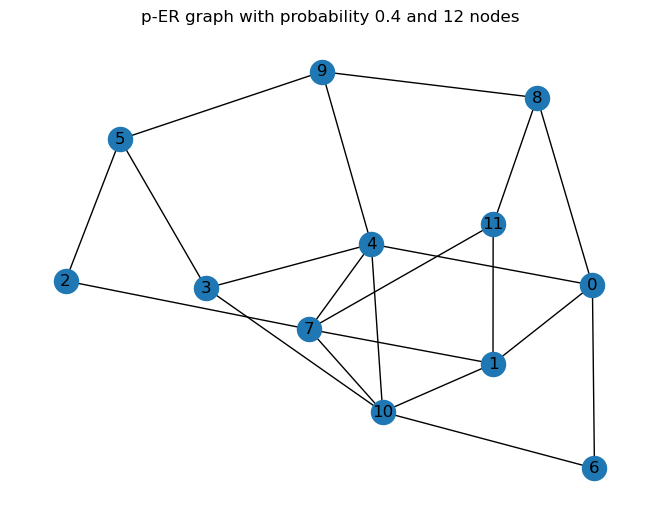

Is H connected? yes


In [8]:
#Try
K = 12
p= 0.4

# Generation of p-ER graph
H = nx.erdos_renyi_graph(K, p)


#First we get the corresponding adjacency matrix
adj_matrix = nx.to_numpy_array(G)
    
# Convert the adjacency matrix to a sparse CSR matrix
#sparse_adj_matrix = sp.csr_matrix(adj_matrix)

# Plotting the p-ER graph
nx.draw(H, with_labels=True)
plt.title(f"p-ER graph with probability {p} and {K} nodes")
plt.show()

#Check connection
print(f"Is H connected? {'yes' if is_connected_method_2(H) else 'no' }")

Lastly we implemented the one using breadth first search.

In [5]:
def bfs_visited_nodes(G, root):
    """
    Performs a breadth-first search (BFS) on the given graph from the root node
    and returns an array of nodes visited during the search in the order of visitation.

    Parameters:
    G (nx.Graph): The input graph.
    root (node): The root node to start the BFS from.

    Returns:
    list: A list of nodes visited during the BFS in the order of visitation.
    """
    # Initialize the list of visited nodes and a set for tracking visited nodes
    visited_nodes = []
    visited_set = set()
    
    # Create an empty queue
    queue = deque()
    
    # Enqueue the root node and mark it as visited
    queue.append(root)
    visited_set.add(root)
    
    # Perform the BFS
    while queue:
        # Dequeue the current node
        current = queue.popleft()
        
        # Add the current node to the list of visited nodes
        visited_nodes.append(current)
        
        # Iterate through each adjacent node
        for neighbor in G.neighbors(current):
            # If the neighbor has not been visited yet
            if neighbor not in visited_set:
                # Mark the neighbor as visited
                visited_set.add(neighbor)
                
                # Enqueue the neighbor
                queue.append(neighbor)
    
    return visited_nodes


def is_connected_method_3(G):
    
    nodes = list(G.nodes)
    n = len(nodes)
    
    # Choose a random node from the list of nodes that will be
    # the root of our bfs algorithm  
    random_node = random.choice(nodes)
    
    # Bfs
    visited_nodes = bfs_visited_nodes(G, root=random_node)
    
    
    # The graph is connected iff the bfs has found all the possible nodes
    # i.e. the graph is connected iff the length of bfs_visited_nodes = n length of all the nodes  
    is_connected = (len(visited_nodes) == n)

    return is_connected


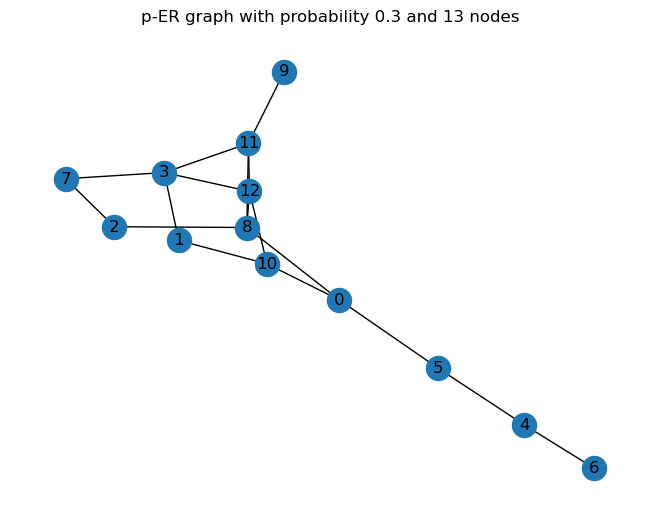

Is H connected? yes


In [10]:
#Try
K = 13
p= 0.3

# Generation of p-ER graph
H = nx.erdos_renyi_graph(K, p)
   
# Convert the adjacency matrix to a sparse CSR matrix
#sparse_adj_matrix = sp.csr_matrix(adj_matrix)

# Plotting the p-ER graph
nx.draw(H, with_labels=True)
plt.title(f"p-ER graph with probability {p} and {K} nodes")
plt.show()

#Check connection
print(f"Is H connected? {'yes' if is_connected_method_3(H) else 'no' }")

### 3) Compare the complexity as a function of K of the methods above by plotting curves of a complexity measure vs K.

Let's try with the first algorithm

In [72]:
num_iter = 500
K = 300
step_size = 20

running_times = {}

for k in range(3, K, step_size):
    
    G = nx.complete_graph(k)  # For example, using a complete graph
    
    # Array to store running times
    avg_running_times = []

    # Measure running time `num_runs` times
    for _ in range(num_iter):         

        start_time = time.time()
        
        # Run the algorithm
        is_connected_method_1(G)
        end_time = time.time()

        # Calculate running time and append to the array
        running_time = end_time - start_time
        avg_running_times.append(running_time)

    # Convert running times array to a NumPy array for easy calculations
    avg_running_times = np.array(avg_running_times)

    # Calculate the average running time of the k-th iteration
    average_running_time = np.mean(avg_running_times)
    
    running_times[k] = average_running_time


x_method_1 = list(running_times.keys())
y_method_1 = list(running_times.values())


C:\Users\franc\AppData\Local\Temp\ipykernel_8980\3092775385.py:22: RuntimeWarning: overflow encountered in matmul
  A_new = np.matmul(A,A_old) + np.eye(n)
C:\Users\franc\AppData\Local\Temp\ipykernel_8980\3092775385.py:22: RuntimeWarning: invalid value encountered in matmul
  A_new = np.matmul(A,A_old) + np.eye(n)


In [74]:
# Specify the file path
file_path = 'y_method_1.csv'

# Open the CSV file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a writer object
    writer = csv.writer(csvfile)
    # Write the list to the CSV file
    writer.writerow(y_method_1)

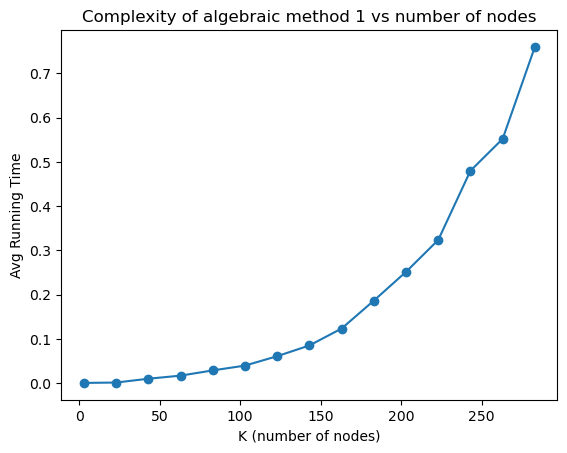

In [95]:
# Create a line plot
plt.figure()
plt.plot(x_method_1, y_method_1, marker='o')  # Add markers for data points
    
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Running Time')
plt.title('Complexity of algebraic method 1 vs number of nodes')

# Save the plot
plt.savefig('Complexity of method 1.png')

# Display the plot
plt.show()

Then with the 2nd one.

In [22]:
num_iter = 500
K = 300
step_size = 20

running_times = {}

for k in range(3, K, step_size):
    
    G = nx.complete_graph(k)  # For example, using a complete graph
    
    # Array to store running times
    avg_running_times = []

    # Measure running time `num_runs` times
    for _ in range(num_iter):         

        start_time = time.time()
        
        # Run the algorithm
        is_connected_method_2(G)
        end_time = time.time()

        # Calculate running time and append to the array
        running_time = end_time - start_time
        avg_running_times.append(running_time)

    # Convert running times array to a NumPy array for easy calculations
    avg_running_times = np.array(avg_running_times)

    # Calculate the average running time of the k-th iteration
    average_running_time = np.mean(avg_running_times)
    
    running_times[k] = average_running_time


x_method_2 = list(running_times.keys())
y_method_2 = list(running_times.values())
    


In [39]:
# Specify the file path
file_path = 'y_method_2.csv'

# Open the CSV file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a writer object
    writer = csv.writer(csvfile)
    # Write the list to the CSV file
    writer.writerow(y_method_2)

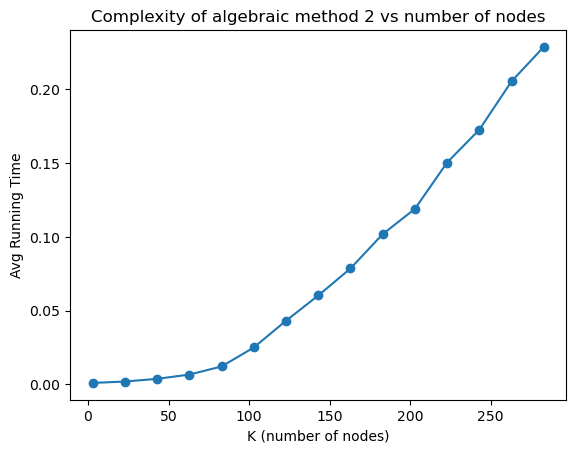

In [94]:
# Create a line plot
plt.figure()
plt.plot(x_method_2, y_method_2, marker='o')  # Add markers for data points
    
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Running Time')
plt.title('Complexity of algebraic method 2 vs number of nodes')

# Save the plot
plt.savefig('Complexity of method 2.png')

# Display the plot
plt.show()

3rd algorithm

In [28]:
num_iter = 1000
K = 300
step_size = 20

running_times = {}

for k in range(3, K, step_size):

    G = nx.complete_graph(k)
    
    # Array to store running times
    avg_running_times = []

    # Measure running time `num_runs` times
    for _ in range(num_iter):         

        start_time = time.time()
        
        # Run the algorithm
        is_connected_method_3(G)
        end_time = time.time()

        # Calculate running time and append to the array
        running_time = end_time - start_time
        avg_running_times.append(running_time)

    # Convert running times array to a NumPy array for easy calculations
    avg_running_times = np.array(avg_running_times)

    # Calculate the average running time of the k-th iteration
    average_running_time = np.mean(avg_running_times)
    
    running_times[k] = average_running_time
x_method_3 = list(running_times.keys())
y_method_3 = list(running_times.values())

In [40]:
# Specify the file path
file_path = 'y_method_3.csv'

# Open the CSV file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a writer object
    writer = csv.writer(csvfile)
    # Write the list to the CSV file
    writer.writerow(y_method_3)

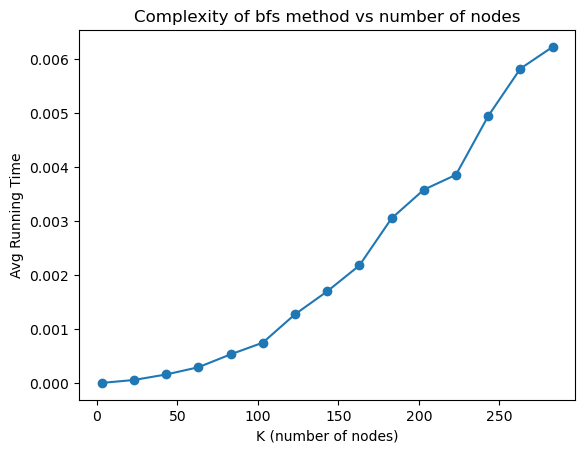

In [93]:
# Create a line plot
plt.figure()
plt.plot(x_method_3, y_method_3, marker='o')  # Add markers for data points
    
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Running Time')
plt.title('Complexity of bfs method vs number of nodes')

# Save the plot
plt.savefig('Complexity of method 3.png')

# Display the plot
plt.show()

## Putting curves together

In [77]:
# Function to read data from a CSV file and return it as a list
def read_csv_to_list(file_path):
    data = []
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    return data
# File paths
file_path_method_1 = 'y_method_1.csv'
file_path_method_2 = 'y_method_2.csv'
file_path_method_3 = 'y_method_3.csv'



In [78]:
# Read data from CSV files into lists
y_method_1 = (read_csv_to_list(file_path_method_1))[0]
y_method_2 = (read_csv_to_list(file_path_method_2))[0]
y_method_3 = (read_csv_to_list(file_path_method_3))[0]

# Convert elements in y_method_2 from strings to floats
y_method_1 = [float(value) for value in y_method_1]
y_method_2 = [float(value) for value in y_method_2]
y_method_3 = [float(value) for value in y_method_3]

# x-axis
K = 300
step_size = 20
x_values = list(range(3, K, step_size))
print(y_method_2)

[0.0009454717636108398, 0.001885915756225586, 0.0037213320732116697, 0.006616315364837646, 0.012121610641479492, 0.02500616931915283, 0.04314081573486328, 0.06022789525985718, 0.0785447497367859, 0.10183331441879273, 0.11895067310333252, 0.15039094161987304, 0.17264644098281862, 0.20539994716644286, 0.228764808177948]


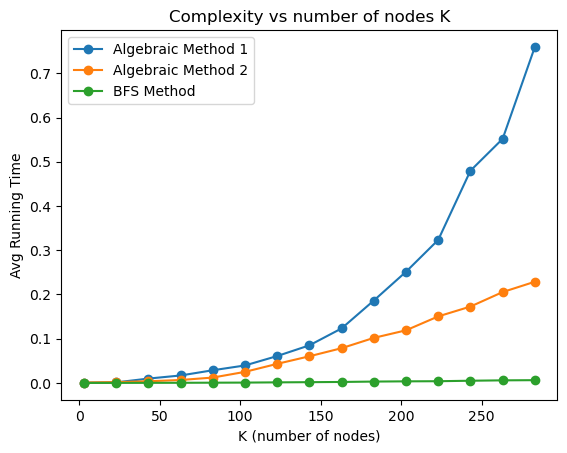

In [84]:
plt.figure()
# Plot the curves
plt.plot(x_values, y_method_1, label='Algebraic Method 1',marker = 'o')
plt.plot(x_values, y_method_2, label='Algebraic Method 2',marker = 'o')
plt.plot(x_values, y_method_3, label='BFS Method',marker = 'o')

# Add labels and title
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Running Time')
plt.title('Complexity vs number of nodes K')

# Add legend
plt.legend()

# Save the plot
plt.savefig('Complexity all method.png')

# Show plot
plt.show()

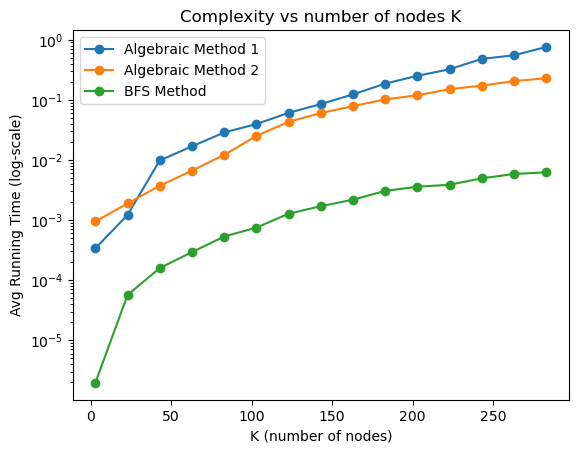

In [85]:
plt.figure()
# Plot the curves
plt.plot(x_values, y_method_1, label='Algebraic Method 1',marker = 'o')
plt.plot(x_values, y_method_2, label='Algebraic Method 2',marker = 'o')
plt.plot(x_values, y_method_3, label='BFS Method',marker = 'o')

# Add labels and title
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Running Time (log-scale)')
plt.title('Complexity vs number of nodes K')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add legend
plt.legend()

# Save the plot
plt.savefig('Complexity all method logscale.png')

# Show plot
plt.show()

### 4) Monte Carlo approximation for the connection probability

1) pc (G) vs. p for Erdos-Renyi graphs with K = 100.

In [91]:
def conn_prob(p):
    
    # simulations for Monte Carlo approximation
    N_iter = 500
    
    is_connected_values = []

    for _ in range(N_iter):
        
        #Generation of the graph
        G = nx.erdos_renyi_graph(K, p)
        
        is_connected_values.append(is_connected_method_3(G))
        
    avg_prob = sum(is_connected_values)/len(is_connected_values)
    
    return avg_prob

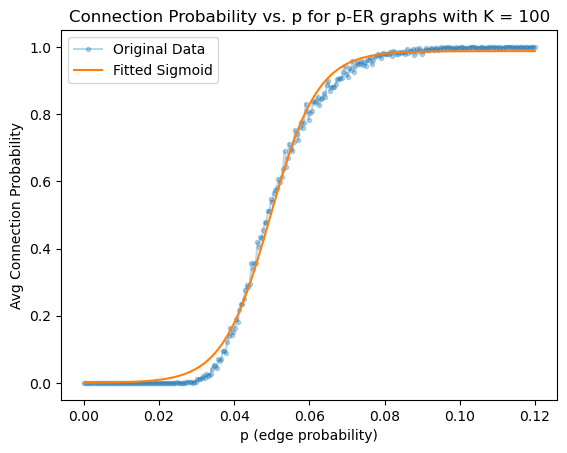

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to calculate sigmoid
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

# Number of nodes
K = 100

prob_values = {}

# Monte Carlo approximation
num_values = 300  # Number of partitions of [0, 1]

for p in np.linspace(0, 0.12, num_values):
    prob_values[p] = conn_prob(p)

x = np.array(list(prob_values.keys()))
y = np.array(list(prob_values.values()))

# Fit sigmoid function to the data
popt, pcov = curve_fit(sigmoid, x, y, maxfev=10000)

# Generate smoothed data using fitted sigmoid function
x_smooth = np.linspace(min(x), max(x), 500)
y_smooth = sigmoid(x_smooth, *popt)

# Plot the original data points and the fitted sigmoid function
plt.figure()
plt.plot(x, y, marker='.', alpha = 0.3, label='Original Data')  # Original data points
plt.plot(x_smooth, y_smooth, label='Fitted Sigmoid')  # Fitted sigmoid function
# Add labels and title
plt.xlabel('p (edge probability)')
plt.ylabel('Avg Connection Probability')
plt.title('Connection Probability vs. p for p-ER graphs with K = 100')
plt.legend()


# Save the plot
plt.savefig('Connection Prob p-er-graph.png')

plt.show()


2. pc (G) vs. K, for K ≤ 100, for r-regular random graphs with r = 2 and r = 8.

In [34]:
def conn_prob(K,r):
    
    # simulations 
    N = 1000
    
    is_connected_values = []

    for _ in range(N):
        
        # Generation of r-regular graph
        G = nx.random_regular_graph(r, K)
        
        is_connected_values.append(is_connected_method_3(G))
        
    avg_prob = sum(is_connected_values)/len(is_connected_values)
    
    return avg_prob

First we try with r = 2

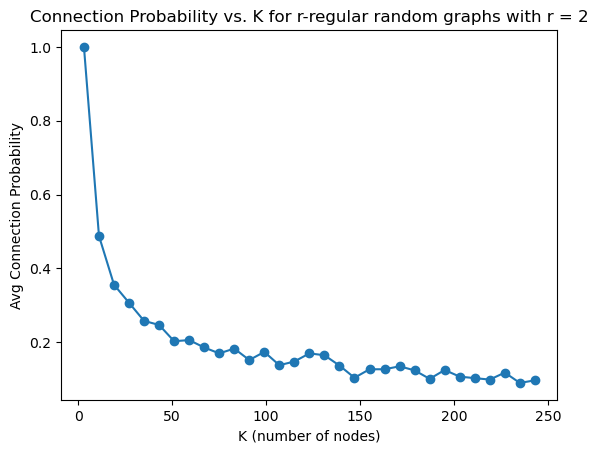

In [36]:
#define r
r = 2

# max number of nodes
K = 250

prob_values = {}

#Monte carlo approximation

step_size = 8

for k in range(3, K, step_size):
    
    prob_values[k] = conn_prob(k,r)


x = list(prob_values.keys())
y = list(prob_values.values())
    
# Create a line plot
plt.figure()
plt.plot(x, y, marker='o')  # Add markers for data points
    
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Connection Probability')
plt.title('Connection Probability vs. K for r-regular random graphs with r = 2')
plt.savefig('Connection Prob regual random graph r = 2.png')


Now let's try with r=8

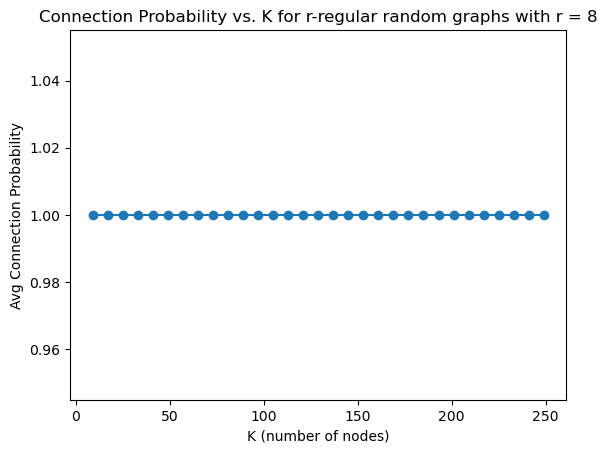

In [37]:
#define r
r = 8

# max number of nodes
K = 250

prob_values = {}

#Monte carlo approximation

step_size = 8

for k in range(9, K, step_size):
    
    prob_values[k] = conn_prob(k,r)


x = list(prob_values.keys())
y = list(prob_values.values())
    
# Create a line plot
plt.figure()
plt.plot(x, y, marker='o')  # Add markers for data points
    
# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Connection Probability')
plt.title('Connection Probability vs. K for r-regular random graphs with r = 8')
plt.savefig('Connection Prob regual random graph r = 8.png')

## Put the plots together

In [86]:
#define r
r = 2

# max number of nodes
K = 250

prob_values = {}

#Monte carlo approximation

step_size = 8

for k in range(3, K, step_size):
    
    prob_values[k] = conn_prob(k,r)


x = list(prob_values.keys())
y = list(prob_values.values())

In [87]:
#define r
r = 8

# max number of nodes
K = 250

prob_values = {}

#Monte carlo approximation

step_size = 8

for k in range(9, K, step_size):
    
    prob_values[k] = conn_prob(k,r)


x_8 = list(prob_values.keys())
y_8 = list(prob_values.values())

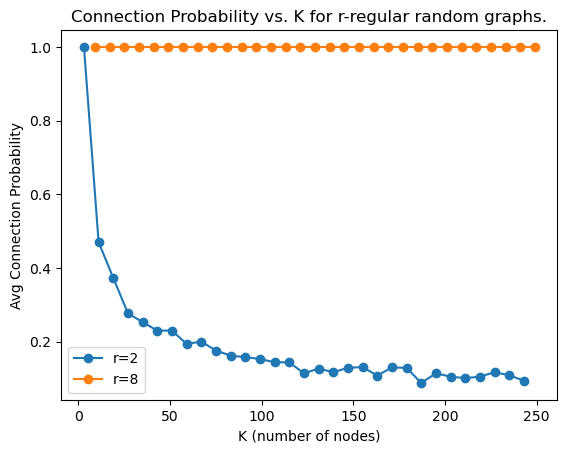

In [89]:
plt.figure()
# Plot the curves
plt.plot(x, y, label='r=2',marker = 'o')
plt.plot(x_8, y_8, label='r=8',marker = 'o')


# Add labels and title
plt.xlabel('K (number of nodes)')
plt.ylabel('Avg Connection Probability')
plt.title('Connection Probability vs. K for r-regular random graphs.')



# Add legend
plt.legend()

plt.savefig('Connection Prob regual random graph all.png')

# Show plot
plt.show()